In [3]:
import pickle
import os
import matplotlib.pyplot as plt

In [2]:
def best_value(Y,sign=1):
    '''
    Returns a vector whose components i are the minimum (default) or maximum of Y[:i]
    '''
    Y_best = list(Y)
    global_val = Y[0]
    for i in range(len(Y_best)):
        if sign == 1:
            global_val = min(Y[i], global_val)
        else:
            global_val = max(Y[i], global_val)
        Y_best[i] = global_val
    return Y_best

In [7]:
#path = '/Users/signapoop/Desktop/autotune/autotune/data'
#os.chdir(path)
file = open("cifar.pkl",'rb')
object_file = pickle.load(file)
file.close()

# Unpack file
hyperband = {}
random = {}
hyperband['arms'] = object_file[0]
hyperband['checkpoints'] = object_file[1]
hyperband['Y'] = object_file[2]
random['arms'] = object_file[3]
random['checkpoints'] = object_file[4]
random['Y'] = object_file[5]

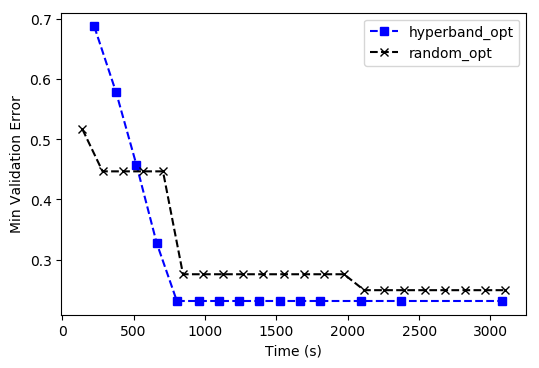

In [6]:
# Plot convergence
fig, ax = plt.subplots(1,1, figsize=(6, 4), dpi=100)
ax.plot(hyperband['checkpoints'], best_value(hyperband['Y']), '--bs', label='hyperband_opt')
ax.plot(random['checkpoints'], best_value(random['Y']), '--kx', label='random_opt')
plt.ylabel('Min Validation Error'); plt.xlabel('Time (s)');
plt.legend()
plt.show()

In [ ]:
# Plot parallel coordinates with plotly